In [1]:
import numpy as np
import torch, pickle

from astropy.table import Table

from spenderq import util as U

In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
bal = Table.read('/tigress/chhahn/spender_qso/london/contamin/bal_cat.fits')
dla = Table.read('/tigress/chhahn/spender_qso/london/contamin/dla_cat_mask_20.30.fits')

In [4]:
tids_bal_dla = np.concatenate([np.array(bal['TARGETID']), np.array(dla['TARGETID'])])

In [8]:
niter, ibatch = 3, 0
with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:            
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
has_bal_dla = np.zeros(len(target_id)).astype(bool)
for i, tid in enumerate(np.array(target_id)): 
    if tid in tids_bal_dla: 
        has_bal_dla[i] = True
print('%i flagged for BAL/DLA' % (np.sum(has_bal_dla)))

true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

290 flagged for BAL/DLA


170278301, yes BAL, no DLA
170278615, no BAL, yes DLA
170280068, no BAL, yes DLA
170280423, yes BAL, yes DLA
170281201, yes BAL, no DLA
170281206, yes BAL, no DLA
170281571, yes BAL, no DLA
170283387, no BAL, yes DLA
170284047, yes BAL, no DLA
170284075, no BAL, yes DLA


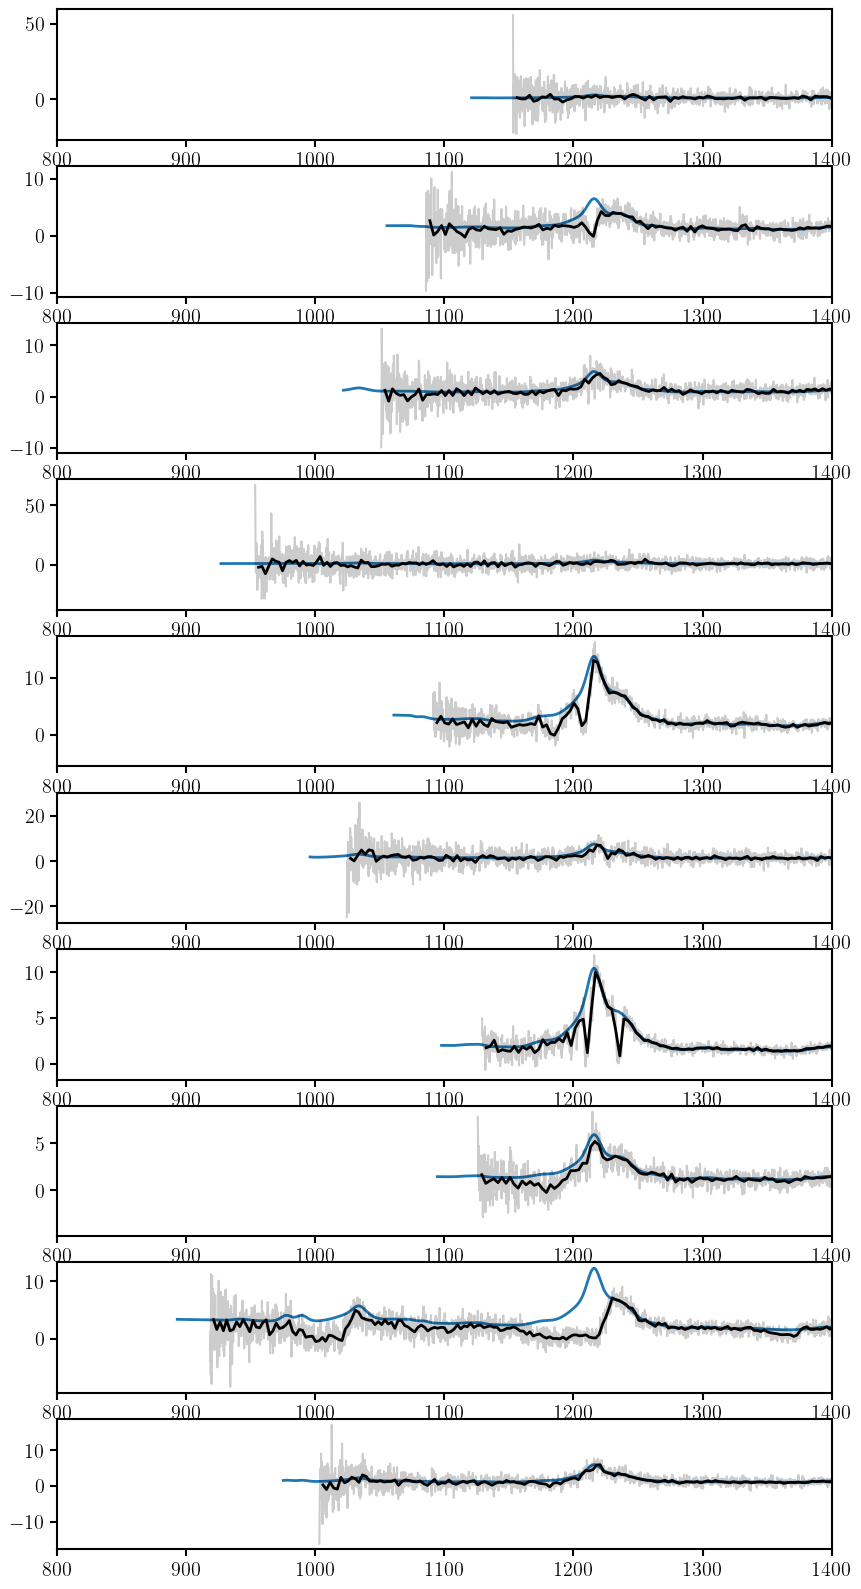

In [12]:
fig = plt.figure(figsize=(10,20))
for i in range(10): 
    sub = fig.add_subplot(10,1,i+1)
    igal = np.arange(len(target_id))[has_bal_dla][i+10]
    
    print('%i, %s, %s' % (int(target_id[igal]), 
                            ['no BAL', 'yes BAL'][int(target_id[igal]) in np.array(bal['TARGETID'])],  
                            ['no DLA', 'yes DLA'][int(target_id[igal]) in np.array(dla['TARGETID'])]))
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1 + np.array(z)[igal]), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Continuum')
    sub.plot(np.linspace(3600., 9824., 7781)/(1.+np.array(z)[igal]), spec[igal], c='k', alpha=0.2)

    wave_rebin = np.arange(3600, 9824, 10)[1:-1]
    spec_rebin = U.trapz_rebin(np.linspace(3600., 9824., 7781), np.array(spec[igal]), xnew=wave_rebin)
    sub.plot(wave_rebin/(1.+np.array(z)[igal]), spec_rebin, c='k', lw=2, label='Coarse-binned')
    sub.set_xlim(800., 1400.)
    #sub.set_ylim()

In [11]:
niter = 3 
counter, new_batch, batch_size = 0, True, 1024

for ibatch in range(100): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:            
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    
    if ibatch < 50: true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))
        
    has_bal_dla = np.zeros(len(target_id)).astype(bool)
    for i, tid in enumerate(np.array(target_id)): 
        if tid in tids_bal_dla: 
            has_bal_dla[i] = True
            
    spec = spec[~has_bal_dla]
    w = w[~has_bal_dla]
    z = z[~has_bal_dla]
    target_id = target_id[~has_bal_dla]
    norm = norm[~has_bal_dla]
    zerr = zerr[~has_bal_dla]
    if ibatch < 50: true_cont = true_cont[~has_bal_dla]

    if new_batch:
        batches = [spec, w, z, target_id, norm, zerr]
        __batches = true_cont
        new_batch = False
    else:
        batches[0] = torch.concatenate([batches[0], spec], axis=0)
        batches[1] = torch.concatenate([batches[1], w], axis=0)
        batches[2] = torch.concatenate([batches[2], z], axis=0)
        batches[3] = torch.concatenate([batches[3], target_id], axis=0)
        batches[4] = torch.concatenate([batches[4], norm], axis=0)
        batches[5] = torch.concatenate([batches[5], zerr], axis=0)
        if ibatch < 50: __batches = np.concatenate([__batches, true_cont], axis=0)

    N = batches[0].shape[0]
    while N > batch_size:
        batch = [_batch[:batch_size] for _batch in batches]
        _batch = __batches[:batch_size]
        print(f"saving batch {counter}")
        
        filename = '/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.no_bal_dla.i%i_%i.pkl' % (niter, counter)
        with open(filename, "wb") as f:
            pickle.dump(batch, f)
        if ibatch < 50: 
            np.save('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.no_bal_dla.true_cont.npy' % (counter), 
                    _batch)
            
        counter += 1
        N -= batch_size

        batches = [_batch[batch_size:] for _batch in batches]   
        if ibatch < 50: __batches = __batches[batch_size:]

saving batch 0
saving batch 1
saving batch 2
saving batch 3
saving batch 4
saving batch 5
saving batch 6
saving batch 7
saving batch 8
saving batch 9
saving batch 10
saving batch 11
saving batch 12
saving batch 13
saving batch 14
saving batch 15
saving batch 16
saving batch 17
saving batch 18
saving batch 19
saving batch 20
saving batch 21
saving batch 22
saving batch 23
saving batch 24
saving batch 25
saving batch 26
saving batch 27
saving batch 28
saving batch 29
saving batch 30
saving batch 31
saving batch 32
saving batch 33
saving batch 34
saving batch 35
saving batch 36
saving batch 37
saving batch 38
saving batch 39
saving batch 40
saving batch 41
saving batch 42
saving batch 43
saving batch 44
saving batch 45
saving batch 46
saving batch 47
saving batch 48
saving batch 49
saving batch 50
saving batch 51
saving batch 52
saving batch 53
saving batch 54
saving batch 55
saving batch 56
saving batch 57
saving batch 58
saving batch 59
saving batch 60
saving batch 61
saving batch 62
sa

In [12]:
batch = [_batch[:batch_size] for _batch in batches]

print(f"saving batch {counter}")

filename = '/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p1sb0p8.no_bal_dla.i%i_%i.pkl' % (niter, counter)
with open(filename, "wb") as f:
    pickle.dump(batch, f)

saving batch 74
